# Libs

In [1]:
import time
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from bernstein_flow.activations import get_thetas_constrain_fn
from bernstein_flow.bijectors import BernsteinBijectorLinearExtrapolate
from bernstein_flow.distributions import BernsteinFlow
from bernstein_flow.util.visualization import plot_flow
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras as K
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability.python.internal import (
    dtype_util,
    prefer_static,
    tensor_util,
)

2023-03-27 17:01:30.080086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 17:01:30.080104: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Seed

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Functions

In [3]:
# Construct and fit model.
# @tf.function
def fit_distribution(
    model,
    learning_rate=0.001,
    lr_patience=5,
    **kwds,
):
    set_seed(1)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=lambda y, dist: -dist.log_prob(y),
    )

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=lr_patience,
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3 * lr_patience,
            restore_best_weights=True,
        ),
        tf.keras.callbacks.TerminateOnNaN(),
    ]

    return model.fit(
        shuffle=True,
        callbacks=callbacks,
        **kwds,
    )

In [4]:
def plot_samples(dist, train_data, seed=1, ax=plt):
    set_seed(seed)
    N = train_data.shape[0]
    # Use the fitted distribution.
    start = time.time()
    samples = dist.sample((N,))
    end = time.time()
    print(f"sampling took {end-start} seconds.")

    df1 = pd.DataFrame(columns=["x1", "x2"], data=train_data)
    df1 = df1.assign(source="data")

    df2 = pd.DataFrame(columns=["x1", "x2"], data=samples.numpy())
    df2 = df2.assign(source="model")

    df = df1.append(df2, ignore_index=True)

    # sns.jointplot(data=df, x='x1', y='x2', hue='source', kind='kde')
    g = sns.jointplot(data=df, x="x1", y="x2", hue="source", ax=plt)
    g.plot_joint(sns.kdeplot, zorder=0)
    # g.plot_marginals(sns.rugplot, height=-.15)

# Data

In [5]:
data = pd.read_csv("india.raw", sep="\s+")

In [6]:
targets = ["stunting", "wasting", "underweight"]
covariates = data.columns[~data.columns.isin(targets)].to_list()

In [7]:
test_size = 0.1
val_size = 0.1

In [8]:
set_seed(1)
train_val_data, test_data = train_test_split(data, test_size=test_size, shuffle=True)
train_data, val_data = train_test_split(
    train_val_data, test_size=val_size, shuffle=True
)
del train_val_data, data

In [9]:
ct = make_column_transformer(
    (MinMaxScaler(), targets),
    remainder=StandardScaler(),
    verbose_feature_names_out=False,
)
ct.set_output(transform="pandas")

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['stunting', 'wasting', 'underweight'])],
                  verbose_feature_names_out=False)

In [10]:
train_data_scaled = ct.fit_transform(train_data)
val_data_scaled = ct.transform(val_data)
test_data_scaled = ct.transform(test_data)

In [11]:
assert train_data_scaled.index.isin(test_data_scaled.index).any() == False
assert train_data_scaled.index.isin(val_data_scaled.index).any() == False
assert val_data_scaled.index.isin(test_data_scaled.index).any() == False

In [12]:
t = partial(tf.convert_to_tensor, dtype=tf.float32)

In [13]:
train_x, train_y = t(train_data_scaled[covariates]), t(train_data_scaled[targets])
val_x, val_y = t(val_data_scaled[covariates]), t(val_data_scaled[targets])
test_x, test_y = t(test_data_scaled[covariates]), t(test_data_scaled[targets])

2023-03-27 17:01:33.692773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-27 17:01:33.692805: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-27 17:01:33.692847: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arch.MarcelPC.fritz.box): /proc/driver/nvidia/version does not exist
2023-03-27 17:01:33.693232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


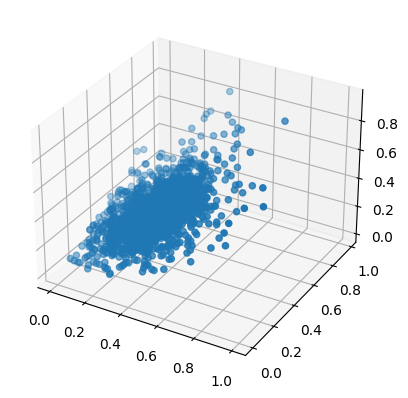

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*train_data_scaled[targets].sample(frac=0.1).values.T)

In [15]:
def plot_samples_grid(data, **kwds):
    sns.set_theme(style="white")

    g = sns.PairGrid(data, diag_sharey=False, **kwds)
    g.map_upper(sns.scatterplot, s=15)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=2)
    return g

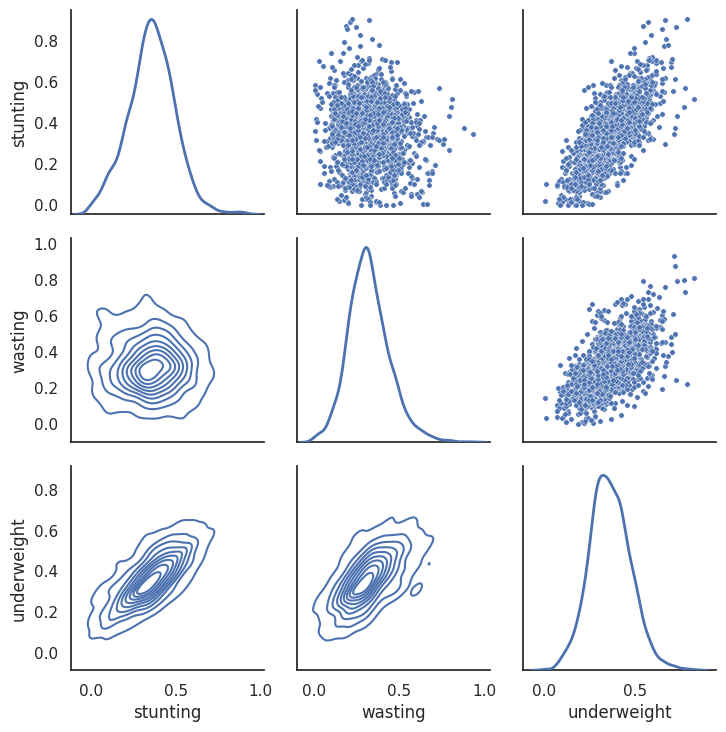

In [16]:
plot_samples_grid(train_data_scaled[targets].sample(frac=0.1))

# Multivariate Conditional Transformation Models

the model-based density function for $Y$ is therefore

$f_{\boldsymbol{Y}}(\boldsymbol{y})=\prod_{j=1}^{J} \phi_{0,1}\left(\lambda_{j 1} \tilde{h}_{1}\left(y_{1}\right)+\ldots+\lambda_{j, j-1} \tilde{h}_{j-1}\left(y_{j-1}\right)+\tilde{h}_{j}\left(y_{j}\right)\right) \frac{\partial \tilde{h}_{j}\left(y_{j}\right)}{\partial y_{j}}$

Summarising the model's specifications, our multivariate transformation model is characterised by a set of marginal transformations $\tilde{h}_{j}\left(y_{j}\right), j=1, \ldots, J$, each applying to only a single component of the vector $\boldsymbol{Y}$, and by a lower triangular $(J \times J)$ matrix of transformation coefficients

$\boldsymbol{\Lambda}=\left(\begin{array}{ccccc}1 & & & & 0 \\ \lambda_{21} & 1 & & & \\ \lambda_{31} & \lambda_{32} & 1 & & \\ \vdots & \vdots & & \ddots & \\ \lambda_{J 1} & \lambda_{J 2} & \ldots & \lambda_{J, J-1} & 1\end{array}\right)$

For the transformation functions $\tilde{h}_{j}$, the explicit representation
$$
\tilde{h}_{j}\left(Y_{j}\right)=\Phi_{0, \sigma_{j}^{2}}^{-1}\left(F_{j}\left(Y_{j}\right)\right)=\tilde{Z}_{j}
$$
is obtained, where $F_{j}(\cdot)$ is the univariate marginal CDF of $Y_{j}$. In summary,
$$
\begin{aligned}
\mathbb{P}(\boldsymbol{Y} \leq \boldsymbol{y}) &=\mathbb{P}(\tilde{\boldsymbol{Z}} \leq \tilde{\boldsymbol{z}})=\Phi_{0, \boldsymbol{\Sigma}}(\tilde{\boldsymbol{z}})=\Phi_{\mathbf{0}, \boldsymbol{\Sigma}}\left[\Phi_{0, \sigma_{1}^{2}}^{-1}\left\{F_{1}\left(y_{1}\right)\right\}, \ldots, \Phi_{0, \sigma_{J}^{2}}^{-1}\left\{F_{J}\left(y_{J}\right)\right\}\right] \\
&=\Phi_{0, \boldsymbol{\Sigma}}\left(\tilde{h}_{1}\left(y_{1}\right), \ldots, \tilde{h}_{J}\left(y_{J}\right)\right)
\end{aligned}
$$
and therefore the CDF of $\boldsymbol{Y}$ has exactly the same structure as a Gaussian copula, except that our representation relies on a different parameterisation of $\boldsymbol{\Sigma}$ through $\boldsymbol{\Sigma}=\Lambda^{-1} \Lambda^{-\top}$.

## Parameter Model

In [17]:
def get_model(input_shape, output_shape, dist_lambda):
    set_seed(1)
    inputs = K.Input(input_shape)
    x = K.layers.Dense(32, activation="relu", name="hidden1")(inputs)
    x = K.layers.Dense(32, activation="relu", name="hidden2")(x)
    pv = K.layers.Dense(output_shape, activation="linear", name="pv")(x)
    dist = tfp.layers.DistributionLambda(dist_lambda)(pv)
    param_model = K.Model(inputs=inputs, outputs=dist)
    param_model.summary()
    return param_model

In [18]:
P = partial(get_model, input_shape=len(covariates))

In [19]:
dims = len(targets)

## Multivariate Normal

In [20]:
def get_multivariate_normal_lambda(dims):
    def lmbd(pv):
        loc = pv[..., :dims]
        scale_tril = tfp.bijectors.FillScaleTriL()(pv[..., dims:])
        mv_normal = tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril)
        return mv_normal

    return lmbd

In [21]:
mn_model = P(
    output_shape=dims + np.sum(np.arange(dims + 1)),
    dist_lambda=get_multivariate_normal_lambda(dims),
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 hidden1 (Dense)             (None, 32)                1312      
                                                                 
 hidden2 (Dense)             (None, 32)                1056      
                                                                 
 pv (Dense)                  (None, 9)                 297       
                                                                 
 distribution_lambda (Distri  ((None, 3),              0         
 butionLambda)                (None, 3))                         
                                                                 
Total params: 2,665
Trainable params: 2,665
Non-trainable params: 0
___________________________________________________________

In [22]:
fit_distribution(
    mn_model,
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=32,
    epochs=100,
    # steps_per_epoch=2,
    learning_rate=0.01,
    lr_patience=2,
)

Epoch 1/100
615/615 [==============================] - 3s 3ms/step - loss: -1.2106 - val_loss: -1.8864 - lr: 0.0100
Epoch 2/100
615/615 [==============================] - 1s 2ms/step - loss: -3.3954 - val_loss: -4.6207 - lr: 0.0100
Epoch 3/100
615/615 [==============================] - 1s 2ms/step - loss: -4.8654 - val_loss: -5.3732 - lr: 0.0100
Epoch 4/100
615/615 [==============================] - 1s 2ms/step - loss: -4.5171 - val_loss: -5.3928 - lr: 0.0100
Epoch 5/100
615/615 [==============================] - 1s 2ms/step - loss: -5.5484 - val_loss: -5.2845 - lr: 0.0100
Epoch 6/100
615/615 [==============================] - 1s 2ms/step - loss: -5.5378 - val_loss: -5.9744 - lr: 0.0100
Epoch 7/100
615/615 [==============================] - 1s 2ms/step - loss: -5.1105 - val_loss: -3.4733 - lr: 0.0100
Epoch 8/100
615/615 [==============================] - 1s 2ms/step - loss: -5.3421 - val_loss: -5.2354 - lr: 0.0100
Epoch 9/100
615/615 [==============================] - 1s 2ms/step - los

In [23]:
mn_samples = mn_model(val_x).sample(10)
mn_samples.shape

TensorShape([10, 2186, 3])

In [24]:
df = pd.DataFrame(mn_samples.numpy().reshape([-1, 3]), columns=targets)

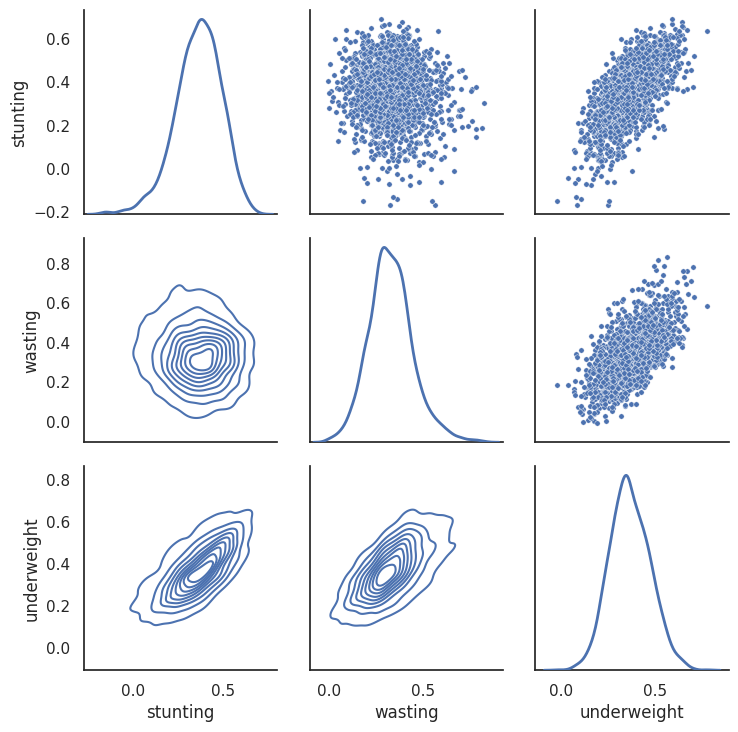

In [25]:
plot_samples_grid(df.sample(frac=0.1))

## BernsteinCopulaTriLtrain_data_scaled

In [26]:
class BernsteinCopulaTriL(BernsteinFlow):
    def __init__(self, thetas, scale_tril, name="BernsteinCopulaTriL", **kwds):
        with tf.name_scope(name) as name:
            parameters = dict(locals())
            dtype = dtype_util.common_dtype([scale_tril, thetas], dtype_hint=tf.float32)

            scale_tril = tensor_util.convert_nonref_to_tensor(
                scale_tril, dtype=dtype, name="scale_tril"
            )

            # scale_tril = tf.linalg.inv(lmbd) @ tf.linalg.inv(tf.transpose(lmbd))
            # scale_tril = tfp.math.
            mv_normal = tfd.MultivariateNormalTriL(loc=0, scale_tril=scale_tril)
            # print(mv_normal)
            super().__init__(
                thetas=thetas,
                base_distribution=mv_normal,
                name=name,
                **kwds,
            )
            self._parameters = parameters

    def _parameter_properties(self, dtype=None, num_classes=None):
        # Annotations may optionally specify properties, such as `event_ndims`,
        # `default_constraining_bijector_fn`, `specifies_shape`, etc.; see
        # the `ParameterProperties` documentation for details.
        return dict(
            lmbd=tfp.util.ParameterProperties(),
        )

In [27]:
bnf_kwds = dict(
    # extrapolation="quadractic",
    bb_class=BernsteinBijectorLinearExtrapolate,
    clip_to_bernstein_domain=False,  # No Sigmoid,
    # scale_data=True,
    # shift_data=True,
    scale_base_distribution=False,
    thetas_constrain_fn=get_thetas_constrain_fn(
        low=-3,
        high=3,
        smooth_bounds=True,
        allow_flexible_bounds=True,
        fn=tf.math.softplus,
        eps=1e-04,
    ),
)

In [28]:
def get_mctm_lambda(dims, M):
    def lmbd(pv):
        tf.print(pv)
        bs = prefer_static.shape(pv)[:-1]
        shape = tf.concat((bs, [dims, M]), 0)
        # shape = (-1, dims, M)
        bnf_pv = tf.reshape(pv[..., : M * dims], shape)
        scale_tril = tfp.math.fill_triangular(pv[..., M * dims :])
        return BernsteinCopulaTriL.from_pvector(
            bnf_pv, scale_tril=scale_tril
        )  # , **bnf_kwds)

    return lmbd

In [29]:
def get_mctm_lambda(dims, M, thetas_constrain_fn):
    def lmbd(pv):
        bs = prefer_static.shape(pv)[:-1]
        shape = tf.concat((bs, [dims, M]), 0)

        thetas = thetas_constrain_fn(tf.reshape(pv[..., : M * dims], shape))
        scale_tril = tfp.bijectors.FillScaleTriL()(pv[..., M * dims :])

        mv_normal = tfd.MultivariateNormalTriL(loc=0, scale_tril=scale_tril)

        return tfd.TransformedDistribution(
            distribution=mv_normal,
            bijector=tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas)),
        )

    return lmbd

In [30]:
thetas_constrain_fn = get_thetas_constrain_fn(
    low=-3,
    high=3,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    eps=1e-04,
)

In [31]:
M = 20
output_shape = dims * M + np.sum(np.arange(dims + 1))

In [32]:
d = get_mctm_lambda(dims, M, thetas_constrain_fn)(tf.ones((output_shape)))

In [33]:
tfp.layers.DistributionLambda(get_mctm_lambda(dims, M, thetas_constrain_fn))(
    tf.ones((output_shape))
)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[] event_shape=[3] dtype=float32>

In [34]:
mctm_model = P(
    output_shape=output_shape, dist_lambda=get_mctm_lambda(dims, M, thetas_constrain_fn)
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40)]              0         
                                                                 
 hidden1 (Dense)             (None, 32)                1312      
                                                                 
 hidden2 (Dense)             (None, 32)                1056      
                                                                 
 pv (Dense)                  (None, 66)                2178      
                                                                 
 distribution_lambda_2 (Dist  ((None, 3),              0         
 ributionLambda)              (None, 3))                         
                                                                 
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________

In [35]:
fit_distribution(
    mctm_model,
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=32,
    epochs=100,
    # steps_per_epoch=2,
    learning_rate=0.01,
    lr_patience=2,
)

Epoch 1/100
615/615 [==============================] - 7s 5ms/step - loss: -5.7948 - val_loss: -7.3306 - lr: 0.0100
Epoch 2/100
615/615 [==============================] - 2s 3ms/step - loss: -7.9693 - val_loss: -8.2760 - lr: 0.0100
Epoch 3/100
615/615 [==============================] - 2s 3ms/step - loss: -8.4970 - val_loss: -8.5082 - lr: 0.0100
Epoch 4/100
615/615 [==============================] - 2s 3ms/step - loss: -8.8447 - val_loss: -9.1831 - lr: 0.0100
Epoch 5/100
615/615 [==============================] - 2s 3ms/step - loss: -9.0045 - val_loss: -9.4900 - lr: 0.0100
Epoch 6/100
615/615 [==============================] - 2s 3ms/step - loss: -9.2034 - val_loss: -9.2653 - lr: 0.0100
Epoch 7/100
615/615 [==============================] - 2s 3ms/step - loss: -9.2679 - val_loss: -9.0016 - lr: 0.0100
Epoch 8/100
615/615 [==============================] - 2s 3ms/step - loss: -10.4809 - val_loss: -10.4044 - lr: 1.0000e-03
Epoch 9/100
615/615 [==============================] - 2s 3ms/step

In [36]:
mctm_samples = mctm_model(val_x).sample(10)
mctm_samples.shape

TensorShape([10, 2186, 3])

In [37]:
df = pd.DataFrame(mctm_samples.numpy().reshape([-1, 3]), columns=targets)

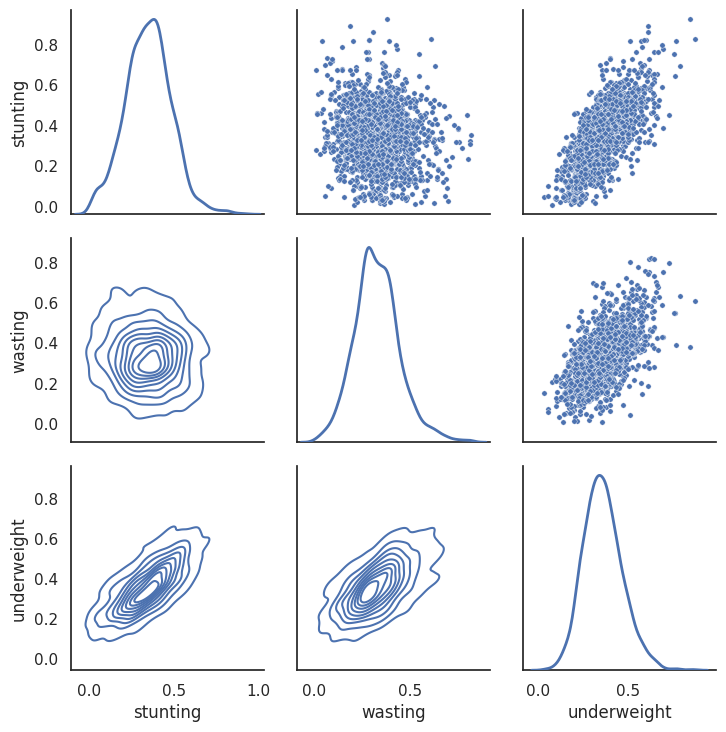

In [38]:
plot_samples_grid(df.sample(frac=0.1))

In [39]:
step = 0.01
xi, yi, zi = np.mgrid[0:1:step, 0:1:step, 0:1:step]
grid = np.stack([xi.flatten(), yi.flatten(), zi.flatten()], 1)

In [40]:
grid.shape

(1000000, 3)

In [41]:
val_x.numpy().mean(-1)

array([ 0.37676445,  0.15323249,  0.43491998, ...,  0.49770993,
        0.27090558, -0.1883369 ], dtype=float32)

In [42]:
d = mctm_model(val_x.numpy().mean(0)[None, ...]).prob(grid).numpy()
d.shape

(1000000,)

In [43]:
#%matplotlib notebook

In [ ]:
import matplotlib
ax = plt.figure().add_subplot(projection="3d")
surf = ax.scatter(
    xi,
    yi,
    zi,
    #c=d / d.max(),
    alpha=d / d.max(),
    cmap=matplotlib.cm.viridis,
    antialiased=False,
)

/tmp/ipykernel_26262/1587873755.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  surf = ax.scatter(


In [44]:
img=d.reshape(xi.shape)

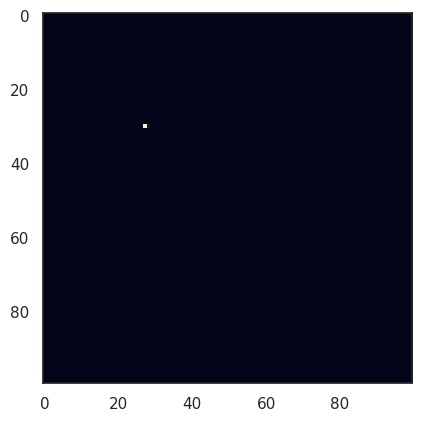

In [45]:
plt.imshow(img[0])

In [46]:
from ipywidgets import interact

In [47]:
@interact(i=(0, zi.shape[0]))
def g(i):
    plt.imshow(img[i])

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

## Masked Autoregressive Flow

## MADE + BNF
https://github.com/tensorchiefs/bfvi/blob/main/R/multidimensional_script.R

In [ ]:
def get_bijector_fn(made, **kwds):
    def bijector_fn(x, **kwds):
        with tf.name_scope("bnf_made_bjector"):
            dtype = made.dtype

            pvector = made(x, **kwds)
            flow = BernsteinFlow.from_pvector(pvector, **kwds)
            bijector = flow.bijector

            return bijector

    return bijector_fn

In [ ]:
set_seed(1)
made1 = tfb.AutoregressiveNetwork(
    params=128,
    hidden_units=[8, 16],
    event_shape=(2,),
    activation="relu",
    conditional=True,
    conditional_event_shape=(len(covariates)),
)
bnf_kwds = dict(
    bb_class=BernsteinBijectorLinearExtrapolate,
    thetas_constrain_fn=get_thetas_constrain_fn(low=-4, high=4, smooth_bounds=True),
    scale_base_distribution=False,
    clip_to_bernstein_domain=False,  # No Sigmoid,
)
bijector_fn = get_bijector_fn(made=made1, **bnf_kwds)
bnf1 = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(0, 1), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(bijector_fn=bijector_fn),
)

In [ ]:
hist = fit_distribution(
    bnf1,
    x_data=train_x,
    y_data=train_y,
    epochs=200,
    learning_rate=0.1,
    extra_variables=made1,
)

In [ ]:
pd.DataFrame(hist.history)[["loss", "val_loss"]].plot()

In [ ]:
plot_samples(bnf2, X_data)

#### 